In [1]:
import numpy as np

#              inxh      c           outc
#       --(Act)---x---+---------(Act)----x-------> h
#      |          |   L<-x--J            |    v
#      |          |i     |f              |o   |
#      |          ~      ~               ~    |
#      wx         wi     wf              wo   |
#      |          |      |               |    |
#      ^----------^------^---------------^    |
#                    |x:h                     |
#  x-------->--------^--------------<---------J
#
class RecurLayer:
    
    def __init__(self, n_x, n_h, x_acti="TANH", h_acti="TANH"):
        self.n_x = n_x
        self.n_h = n_h        
        
        n_w = n_x + n_h
        self.wx = np.random.uniform(-0.1, 0.1, (n_h, n_w))
        self.wi = np.random.uniform(-0.1, 0.1, (n_h, n_w))
        self.wf = np.random.uniform(-0.1, 0.1, (n_h, n_w))
        self.wo = np.random.uniform(-0.1, 0.1, (n_h, n_w))
        self.bx = np.random.uniform(-0.1, 0.1, (n_h, 1))
        self.bi = np.random.uniform(-0.1, 0.1, (n_h, 1))
        self.bf = np.random.uniform(-0.1, 0.1, (n_h, 1))
        self.bo = np.random.uniform(-0.1, 0.1, (n_h, 1))
       
        self.x_acti = Activation(x_acti)
        self.h_acti = Activation(h_acti)
        # initialize input/output and gradients data structure
        self.reset_context()
        
    def forward(self, x):
        #set_trace()
        assert self.n_x == x.size
        
        h = self.h
        xh = np.concatenate((x, h))
        
        inxh = np.dot(self.wx, xh) + self.bx       
        inxh = self.x_acti.func(inxh)
        
        i = np.dot(self.wi, xh) + self.bi
        f = np.dot(self.wf, xh) + self.bf
        o = np.dot(self.wo, xh) + self.bo        
        i = Activation.sigmoid(None, i)
        f = Activation.sigmoid(None, f)
        o = Activation.sigmoid(None, o)

        c = inxh * i + self.c * f # compute c(t), this is core        
        outc = self.h_acti.func(c)
        h = outc * o
        
        # c(t) and h(t) are not used for backwarding, 
        # hence not kept in queue, but in a var for next forwarding
        # c(t-1) and h(t-1) are kept in queue for backwarding
        self.C.append(self.c)    # c(t-1)
        self.c = c                # c(t), 
        self.h = h                # h(t)
        self.XH.append(xh)        # x(t):h(t-1)
        self.I.append(i)
        self.O.append(o)
        self.F.append(f)
        self.inXH.append(inxh)
        self.outC.append(outc)
        
        return h
    
#              inxh      c           outc
#       --(Act)---x---+---------(Act)----x-------> h
#      |          |   L--x--J            |    |
#      |          |i     |f              |o   |
#      |          ~      ~               ~    |
#      wx         wi     wf              wo   |
#      |          |      |               |    |
#      L---------------------------------J    |
#                    |x:h                     |
#  x-----------------^------------------------J
#
    def backward(self, g_h):
        #set_trace()
        #print(self)
        assert g_h.size == self.n_h
        g_h += self.g_h  # plus the g_h from prev backwarding

        outc = self.outC.pop()
        o = self.O.pop()
        f = self.F.pop()
        i = self.I.pop()
        c = self.C.pop()
        inxh = self.inXH.pop()
        xh = self.XH.pop()
        
        g_outc = o * g_h
        g_o = outc * g_h
        
        g_signal_c = self.h_acti.grad(outc)
        g_c = g_signal_c * g_outc

        g_c += self.g_c  # plus the g_c from prev backwarding
        g_f = c * g_c
        g_c = f * g_c 
        self.g_c = g_c   # store g_c for next backwarding
        

        g_i = inxh * g_c
        g_inxh = i * g_c
        g_signal_x = self.x_acti.grad(inxh)
        g_xh_x = g_signal_x * g_inxh
        
        g_signal_i = Activation.g_sigmoid(None, i)
        g_signal_f = Activation.g_sigmoid(None, f)
        g_signal_o = Activation.g_sigmoid(None, o)
        g_xh_i = g_signal_i * g_i
        g_xh_f = g_signal_f * g_f
        g_xh_o = g_signal_o * g_o
        
        g_xh  = np.dot(self.wx.T, g_xh_x)
        g_xh += np.dot(self.wi.T, g_xh_i)
        g_xh += np.dot(self.wf.T, g_xh_f)
        g_xh += np.dot(self.wo.T, g_xh_o)
        self.g_x = g_xh[:self.n_x]
        self.g_h = g_xh[self.n_x:]   # store g_h for next backwarding

        self.g_wx += np.outer(g_xh_x, xh)
        self.g_wi += np.outer(g_xh_i, xh)
        self.g_wf += np.outer(g_xh_f, xh)
        self.g_wo += np.outer(g_xh_o, xh)
        self.g_bx += g_xh_x
        self.g_bi += g_xh_i
        self.g_bf += g_xh_f
        self.g_bo += g_xh_o
        
        return self.g_x
        
    def update(self, learning=0.01):
        self.wx -= self.g_wx * learning
        self.wi -= self.g_wi * learning
        self.wf -= self.g_wf * learning
        self.wo -= self.g_wo * learning
        self.bx -= self.g_bx * learning
        self.bi -= self.g_bi * learning
        self.bf -= self.g_bf * learning
        self.bo -= self.g_bo * learning
        
        assert not self.XH and not self.inXH and not self.C and \
               not self.I  and not self.F and \
               not self.O  and not self.outC
        self.reset_context()
        return
    
    def reset_context(self):
        # initialize the forwarding passes
        self.h    = np.zeros(shape=(self.n_h, 1))
        self.c    = np.zeros(shape=(self.n_h, 1))
        self.C    = []
        self.XH   = []
        self.I    = []
        self.O    = []
        self.F    = []
        self.inXH = []
        self.outC = []
        
        # initialize the backwarding passes
        self.g_h  = np.zeros(shape=(self.n_h, 1))
        self.g_c  = np.zeros(shape=(self.n_h, 1))
        self.g_bx = 0
        self.g_bi = 0
        self.g_bf = 0
        self.g_bo = 0
        self.g_wx = 0
        self.g_wi = 0
        self.g_wf = 0
        self.g_wo = 0
        return
        
    def __str__(self):
        s  = "\nXH is:\n" + str(self.XH)
        s += "\ng_wx is:\n" + str(self.g_wx)
        s += "\ng_wi is:\n" + str(self.g_wi)
        s += "\ng_wf is:\n" + str(self.g_wf)
        s += "\ng_wo is:\n" + str(self.g_wo)
        s += "\ng_bx is:\n" + str(self.g_bx)
        s += "\ng_bi is:\n" + str(self.g_bi)
        s += "\ng_bf is:\n" + str(self.g_bf)
        s += "\ng_bo is:\n" + str(self.g_bo)
        
        return s
        

In [6]:
class RecurNet:
    
    def __init__(self, recurlayer, outlayer, learning=0.01):
        self.type = "RNN"
        assert recurlayer and outlayer
        self.recur = recurlayer
        self.output = outlayer
        self.learning = learning
        return

    def train_1sequence(self, X, Y):
        #set_trace()
        n_sample = X.shape[0]
        g_H = np.empty(shape=(n_sample, self.output.n_x, 1))  
        for i in range(n_sample):
            h = self.recur.forward(X[i])
            self.output.forward(h)            
            g_H[i] = self.output.backward(Y[i])
            self.output.update(self.learning)

        for i in reversed(range(n_sample)):
            self.recur.backward(g_H[i])
        
        self.recur.update(self.learning)
        
        return

    # 1sequence is a sequence of many samples, predicting next one for the sequence     
    def predict_1sequence(self, X):
        n_sample = X.shape[0]
        for i in range(n_sample):
            h = self.recur.forward(X[i])
            y = self.output.forward(h)            

        self.recur.reset_context()
        return y
    
    def train_1batch(self, X, label):
        #set_trace()
        n_sample = X.shape[0]
        for i in range(n_sample):
            h = self.recur.forward(X[i])

        self.output.forward(h)            
        g_h = self.output.backward(label)

        g_H = np.zeros(shape=(n_sample, self.output.n_x, 1)) 
        g_H[-1] = g_h
        for i in reversed(range(n_sample)):
            self.recur.backward(g_H[i])
        
        self.output.update(self.learning)
        self.recur.update(self.learning)
        return
        
    # 1batch is one sample, split into a sequence; predicting output of the sample     
    def predict_1batch(self, X):
        n_sample = X.shape[0]
        for i in range(n_sample):
            h = self.recur.forward(X[i])
        
        y = self.output.forward(h)            
        self.recur.reset_context()
        return y

    # 1sample is like non-recurrent network where no recurrence between samples
    def train_1sample(self, nx, y):
        n = nx.shape[0]
        seq_len = self.recur.n_x
        n_seq = n // seq_len
        X = nx.reshape(n_seq, seq_len, 1)
        self.train_1batch(X, y)
        return
    
    def predict_1sample(self, nx):
        n = nx.shape[0]
        seq_len = self.recur.n_x
        n_seq = n // seq_len
        X = nx.reshape(n_seq, seq_len, 1)
        y = self.predict_1batch(X)
        return y

    def forward(self, x):
        h = self.recur.forward(x)
        y = self.output.forward(h)            
        return y


In [3]:
%run 'MLP.ipynb'

In [4]:
def run_rnn_test():
    n_x=3; n_h=10; n_class=3
    recurlayer = RecurLayer(n_x, n_h)
    outlayer = SoftMaxLayer(n_h, n_class)
    rnn = RecurNet(recurlayer=recurlayer, outlayer=outlayer, learning=0.1)
    X = [
        [1,2,3],
        [2,1,3],
        [3,1,2],
        [3,2,1],
        [1,3,2],
        [2,3,1]
        ]
    Y = [2,2,0,0,1,1]
    X = np.array(X)
    Y = np.array(Y)

    for j in range(30):
#        if j % 10 == 0:
#           print(rnn.recur)
#           print(rnn.output)
            
        for i in range(X.shape[0]):
            rnn.train_1sample(X[i].reshape(n_x,1), Y[i])

    X = np.array([[1,2,3],[2,3,1],[3,1,2]])
    for i in range(X.shape[0]):
        predict = rnn.predict_1sample(X[i].reshape(n_x,1))
        print("\nPredict: ", X[i], predict)

if __name__  == '__main__':
    pass
    run_rnn_test()
    


Predict:  [1 2 3] 2

Predict:  [2 3 1] 1

Predict:  [3 1 2] 0


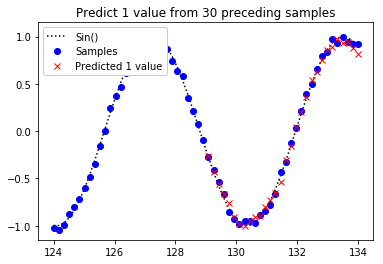

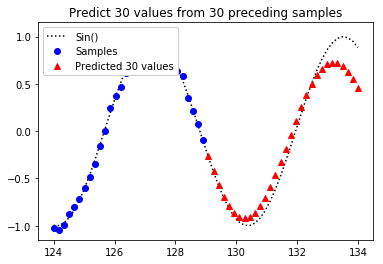

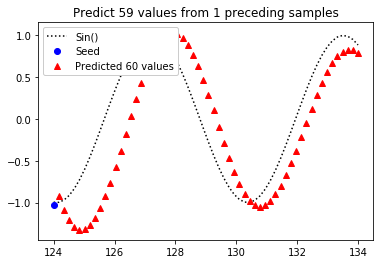

In [15]:
import matplotlib.pylab as plt

def noisize(X):
    Y = X + (np.random.random_sample(X.shape) - 0.5) * 0.1
    return Y

def run_rnn_sine():
    # training data
    n_seq = 500
    seq_len = 30
    scope = 5    # scope < 10
    X = np.linspace(0, 10, seq_len+1)[None, :]
    for i in range(n_seq-1):
        j = np.random.randint(0, 1000)
        X = np.concatenate((X, np.linspace(j, j+scope, seq_len+1)[None, :]))
        
    Label = np.sin(X) 
    Input = noisize(Label)
    
    # build the network
    n_x = 1; n_h= 133; n_y=1
    outlayer = MSELayer(n_h, n_y)
    recurlayer = RecurLayer(n_x, n_h, x_acti="TANH", h_acti="TANH")
    rnn = RecurNet(recurlayer = recurlayer, outlayer=outlayer, learning=0.01)
    
    
    Input = Input[:, :seq_len].reshape(n_seq, seq_len, n_x, 1)
    Label = Label[:, 1:].reshape(n_seq, seq_len, n_x, 1)
    
    # training
    n_epoch = 2
    for j in range(n_epoch):
        for i in range(n_seq):
            rnn.train_1sequence(Input[i], Label[i])
    
    # testing data
    j = np.random.randint(0, 1000)
    new_len = seq_len * 2
    new_scope = scope * 2
    seq_len = new_len // 2
    X = np.linspace(j, j+new_scope, new_len)
    
    Label = np.sin(X)
    Raw = noisize(Label)
    Input = Raw.reshape(new_len, n_x, 1)
    Output = np.zeros(seq_len)
    
    # predicting
    for i in range(seq_len):
        Output[i] = rnn.predict_1sequence(Input[i:(seq_len+i)])

    Newout = Input.copy()
    for i in range(seq_len):
        Newout[seq_len+i][0][0] = rnn.predict_1sequence(Newout[i:(seq_len+i)])
    Newout = Newout.reshape(new_len)
        
    # showing
    plt.plot(X, Label, 'k:', label="Sin()")
    plt.plot(X, Raw, 'bo', label="Samples")
    plt.plot(X[seq_len:], Output, 'rx', label="Predicted 1 value")
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_alpha(1)
    plt.title('Predict 1 value from %d preceding samples'%(seq_len,))
    plt.show()
 
    plt.plot(X, Label, 'k:', label="Sin()")
    plt.plot(X[:seq_len], Raw[:seq_len], 'bo', label="Samples")
    plt.plot(X[seq_len:], Newout[seq_len:], 'r^', label="Predicted %d values"%(seq_len,))
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_alpha(1)
    plt.title('Predict %d values from %d preceding samples'%(seq_len, seq_len))
    plt.show()
    
    Newout = Input.copy()
    for i in range(new_len-1):
        Newout[i+1][0][0] = rnn.forward(Newout[i])
    Newout = Newout.reshape(new_len)
    plt.plot(X, Label, 'k:', label="Sin()")
    plt.plot(X[:1], Newout[:1], 'bo', label="Seed")
    plt.plot(X[1:], Newout[1:], 'r^', label="Predicted %d values"%(new_len-1,))
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_alpha(1)
    plt.title('Predict %d values from %d preceding samples'%(new_len-1, 1))
    plt.show()

if __name__ == "__main__":
    np.seterr(all="raise")
    run_rnn_sine()

In [4]:

%run 'mnist.ipynb'
def run_rnn_mnist():
    n_x = 28; n_h= 28*28+1; n_class=10
    outlayer = SoftMaxLayer(n_h, n_class)
    recurlayer = RecurLayer(n_x, n_h)
    rnn = RecurNet(recurlayer=recurlayer, outlayer=outlayer, learning=0.01)
    mnist = MNIST(rnn, folder="../convolution-network")
    for i in range(5):
        #set_trace()
        mnist.train(-1)
        accuracy = mnist.test(-1)
        print("\nAccuracy of epoch {} is {}".format(i, accuracy))
    return mnist

mnist = None
if __name__  == '__main__':
    pass 
    mnist = run_rnn_mnist()


Accuracy of epoch 0 is 0.9396

Accuracy of epoch 1 is 0.9594

Accuracy of epoch 2 is 0.9722

Accuracy of epoch 3 is 0.9748

Accuracy of epoch 4 is 0.9758
